# Modelling

### Data Load in and Count Vectorizer 

### GridSearch Models
 - [Logistic Regression](#Logistic-Regression)

 - [RandomForestClassifier](#RandomForestClassifier)

 - [Support Vector Machine](#Support-Vector-Machine)

 - [Gradient Boosting](#Gradient-Boosting)

[Choosing the Best Model](#Choosing-the-Best-Model)

[Final Model Performance Test](#Final-Model-Performance-Test )

[Choosing the Threshold](#Choosing-the-Threshold)

[Final Optimized Model Report](#Final-Optimized-Model-Report)

The business would like to create a comment identification system that internally flags posts that may contain bigotry. 
A comment reviewing team will go through the flagged comments and take down comments that contain bigotry by two thirds vote. 
The team estimates it can review up to 10% of comment traffic. 

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, matthews_corrcoef, make_scorer, roc_auc_score, roc_curve, PrecisionRecallDisplay
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import auc
import matplotlib.style
import matplotlib as mpl

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [3]:
X = pd.read_csv(r'/Users/michelstahli/Spring 2022 (Bootcamp+)/Jupyter Notebook CSVs/X_for_vector.csv')
X_train_scaled = pd.read_csv(r'/Users/michelstahli/Spring 2022 (Bootcamp+)/Jupyter Notebook CSVs/X_train_scaled_ob.csv') 
X_val_scaled = pd.read_csv(r'/Users/michelstahli/Spring 2022 (Bootcamp+)/Jupyter Notebook CSVs/X_val_scaled_ob.csv') 
y_train = pd.read_csv(r'/Users/michelstahli/Spring 2022 (Bootcamp+)/Jupyter Notebook CSVs/y_train_ob.csv') 
y_val = pd.read_csv(r'/Users/michelstahli/Spring 2022 (Bootcamp+)/Jupyter Notebook CSVs/y_val_ob.csv') 
X_test_scaled = pd.read_csv(r'/Users/michelstahli/Spring 2022 (Bootcamp+)/Jupyter Notebook CSVs/X_test__scaled_ob.csv')
X_final_train_scaled = pd.read_csv(r'/Users/michelstahli/Spring 2022 (Bootcamp+)/Jupyter Notebook CSVs/X_final_train_scaled_ob.csv')
y_final_train = pd.read_csv(r'/Users/michelstahli/Spring 2022 (Bootcamp+)/Jupyter Notebook CSVs/y_model_ob.csv') 
y_test = pd.read_csv(r'/Users/michelstahli/Spring 2022 (Bootcamp+)/Jupyter Notebook CSVs/y_test_ob.csv') 

### Create vectorizer for all words to fit on. 
 - With more time could have tried different min_df and max_df values. 

In [4]:
def get_word_matrix (X_input):
    bag = X['text_lemmatized']
    vectorizer = CountVectorizer(min_df=0.01, max_df=0.8) #Found this works best in Naive Bayes, consider changing
    fitted_vectorizer = vectorizer.fit(bag)
    word_matrix = fitted_vectorizer.transform(X_input['text_lemmatized'])
    return word_matrix
def get_add_word_matrix (X_input):
    #df_og, df with bag of words replace with vectorized word matrix, X_input
    bag = X['text_lemmatized']
    vectorizer = CountVectorizer(min_df=0.01, max_df=0.8) #Final was 0.01
    fitted_vectorizer = vectorizer.fit(bag)
    word_matrix = fitted_vectorizer.transform(X_input['text_lemmatized'])
    
    df_word_matrix = pd.DataFrame(word_matrix.toarray(), columns = vectorizer.get_feature_names_out())
    df_word_matrix['Unnamed: 0'] = X_input['Unnamed: 0']
    df_merged = X_input.merge(df_word_matrix, on ='Unnamed: 0')
    df_merged = df_merged.drop(columns=['Unnamed: 0', 'text_lemmatized'])
    return df_merged

Create training and validation dfs with count-vectorized matrix added

In [8]:
X_train_scaled_plus = get_add_word_matrix(X_train_scaled)
X_val_scaled_plus = get_add_word_matrix(X_val_scaled)
X_train_scaled_plus = X_train_scaled_plus.drop(columns=['disgust_x', 'surprise_x', 'neutral_x', 'anger_x',
       'sad_x', 'happy_x', 'fear_x']) #For testing emotion score usefulness 
X_val_scaled_plus = X_val_scaled_plus.drop(columns=['disgust_x', 'surprise_x', 'neutral_x', 'anger_x',
       'sad_x', 'happy_x', 'fear_x']) #For testing emotion score usefulness

Make y-labels 1s and 0s

In [9]:
y_train1 = y_train*1
y_train1 = y_train1.drop(columns='Unnamed: 0')
y_train1 = y_train1.to_numpy().ravel()
y_val1 = y_val*1
y_val1 = y_val1.drop(columns='Unnamed: 0')
y_val1 = y_val1.to_numpy().ravel()

In [10]:
y_train1

array([0, 0, 0, ..., 0, 1, 0])

In [11]:
X_train_scaled_plus.head()

,ups,dal,word_count,up_low_ratio,about,actually,after,again,ago,all,...,work,world,would,wow,wrong,yeah,year,yes,you,your
0,0.020278,0.027289,0.007385,0.019608,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.020833,0.023670,0.005538,0.062500,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0.020278,0.211989,0.000615,0.107143,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.020556,0.044095,0.003692,0.062500,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0.020278,0.034278,0.022154,0.068750,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0


## Logistic Regression

For ROC AUC 

Accuracy: 0.7787652645861602
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1340
           1       0.52      0.14      0.22        88

    accuracy                           0.94      1428
   macro avg       0.73      0.56      0.59      1428
weighted avg       0.92      0.94      0.92      1428

Tuned Model Parameters: {'C': 0.1623776739188721, 'penalty': 'l2'}
Precision_score:  0.5217391304347826
Recall_score:  0.13636363636363635
Matthew Corr: 0.24480829518002892
ROC AUC score: 0.7787652645861602


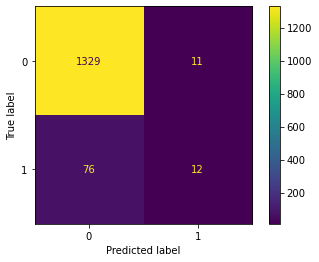

In [13]:
classifier = LogisticRegression(solver='liblinear', random_state=26)
parameter_grid = {
                    'penalty' : ['l1', 'l2'],
                    'C' : np.logspace(-5, 5, 20)
                    }
lcv = GridSearchCV(classifier, parameter_grid, scoring='roc_auc', error_score='raise', cv=4)
lcv.fit(X_train_scaled_plus, y=y_train1)

y_pred = lcv.predict(X_val_scaled_plus)

lcm = confusion_matrix(y_val1, y_pred, labels=lcv.classes_)
# Compute and print metrics
print('For ROC AUC','\n')
print("Accuracy: {}".format(lcv.score(X_val_scaled_plus, y_val1)))
print(classification_report(y_val1, y_pred))
print("Tuned Model Parameters: {}".format(lcv.best_params_))
print('Precision_score: ',precision_score(y_val1, y_pred))
print('Recall_score: ',recall_score(y_val1, y_pred))
print('ROC AUC score:',roc_auc_score(y_val1, lcv.predict_proba(X_val_scaled_plus)[:, 1]))
disp = ConfusionMatrixDisplay(lcm, display_labels=lcv.classes_)
disp.plot()
plt.show()

In [12]:
best_logreg_classifier = LogisticRegression(C=0.1623776739188721, penalty='l1', solver='liblinear', random_state=26)
logisticm = best_logreg_classifier.fit(X_train_scaled_plus, y=y_train1)
logisticauc = roc_auc_score(y_val1, logisticm.predict_proba(X_val_scaled_plus)[:, 1])
print(logisticauc)
lfpr, ltpr, lthresholds = roc_curve(y_val1, logisticm.predict_proba(X_val_scaled_plus)[:, 1])

0.8095191655359568


## RandomForestClassifier 

In [1]:
'''
fclassifier = RandomForestClassifier(random_state=26)


parameter_grid = {
                    'criterion': ["gini", "entropy", "log_loss"],
                    'max_depth': [5, 10, 15, 30, 50, 70],
                    'n_estimators': [15, 50, 100, 200, 500],
                    'max_features': [None]
                
                    }
fcv = GridSearchCV(fclassifier, parameter_grid, scoring='roc_auc', error_score='raise', cv=4)
fcv.fit(X_train_scaled_plus, y=y_train1)

# Predict the labels of the test set: y_pred
fy_pred = fcv.predict(X_val_scaled_plus)
#cv.predict_proba() Threshold 
#y_pred_new_threshold = (lcv.predict_proba(X_val_scaled_plus)[:,1]>=0.20).astype(int)
#matthew's correlation coefficient try

fcm = confusion_matrix(y_val1, fy_pred, labels=fcv.classes_)
# Compute and print metrics
print('For ROC AUC','\n')
print("Accuracy: {}".format(fcv.score(X_val_scaled_plus, y_val1)))
print(classification_report(y_val1, fy_pred))
print("Tuned Model Parameters: {}".format(fcv.best_params_))
print('Precision_score: ',precision_score(y_val1, fy_pred))
print('Recall_score: ',recall_score(y_val1, fy_pred))
print('Matthew Corr:', matthews_corrcoef(y_val1, fy_pred))
print('ROC AUC score:',roc_auc_score(y_val1, fcv.predict_proba(X_val_scaled_plus)[:, 1]))
fdisp = ConfusionMatrixDisplay(fcm, display_labels=fcv.classes_)
fdisp.plot()
plt.show()'''

'\nfclassifier = RandomForestClassifier(random_state=26)\n\n\nparameter_grid = {\n                    \'criterion\': ["gini", "entropy", "log_loss"],\n                    \'max_depth\': [5, 10, 15, 30, 50, 70],\n                    \'n_estimators\': [15, 50, 100, 200, 500],\n                    \'max_features\': [None]\n                \n                    }\nfcv = GridSearchCV(fclassifier, parameter_grid, scoring=\'roc_auc\', error_score=\'raise\', cv=4)\nfcv.fit(X_train_scaled_plus, y=y_train1)\n\n# Predict the labels of the test set: y_pred\nfy_pred = fcv.predict(X_val_scaled_plus)\n#cv.predict_proba() Threshold \n#y_pred_new_threshold = (lcv.predict_proba(X_val_scaled_plus)[:,1]>=0.20).astype(int)\n#matthew\'s correlation coefficient try\n\nfcm = confusion_matrix(y_val1, fy_pred, labels=fcv.classes_)\n# Compute and print metrics\nprint(\'For ROC AUC\',\'\n\')\nprint("Accuracy: {}".format(fcv.score(X_val_scaled_plus, y_val1)))\nprint(classification_report(y_val1, fy_pred))\nprint("

In [13]:
best_random_forest = RandomForestClassifier(criterion='entropy', max_depth=15, max_features=None, n_estimators=500)
forestm = best_random_forest.fit(X_train_scaled_plus, y=y_train1)
forestauc = roc_auc_score(y_val1, forestm.predict_proba(X_val_scaled_plus)[:, 1])
print(forestauc)

ffpr, ftpr, fthresholds = roc_curve(y_val1, forestm.predict_proba(X_val_scaled_plus)[:, 1])

0.8378646540027136


## Support Vector Machine 

In [15]:
'''sclassifier = SVC(random_state=26, probability=True)
parameter_grid = {
                    'kernel': ['rbf'],
                    'C': [0.1, 1, 10, 100, 1000], 
                    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                    }
scv = GridSearchCV(sclassifier, parameter_grid, scoring='roc_auc', error_score='raise', cv=4)
scv.fit(X_train_scaled_plus, y=y_train1)

# Predict the labels of the test set: y_pred
sy_pred = scv.predict(X_val_scaled_plus)
#cv.predict_proba() Threshold 
#y_pred_new_threshold = (lcv.predict_proba(X_val_scaled_plus)[:,1]>=0.20).astype(int)
#matthew's correlation coefficient try

scm = confusion_matrix(y_val1, sy_pred, labels=scv.classes_)
# Compute and print metrics
print('For ROC AUC','\n')
print("Accuracy: {}".format(scv.score(X_val_scaled_plus, y_val1)))
print(classification_report(y_val1, sy_pred))
print("Tuned Model Parameters: {}".format(scv.best_params_))
print('Precision_score: ',precision_score(y_val1, sy_pred))
print('Recall_score: ',recall_score(y_val1, sy_pred))
print('Matthew Corr:', matthews_corrcoef(y_val1, fy_pred))
print('ROC AUC score:',roc_auc_score(y_val1, scv.predict_proba(X_val_scaled_plus)[:, 1]))
sdisp = ConfusionMatrixDisplay(scm, display_labels=scv.classes_)
sdisp.plot()
plt.show()'''

'sclassifier = SVC(random_state=26, probability=True)\nparameter_grid = {\n                    \'kernel\': [\'rbf\'],\n                    \'C\': [0.1, 1, 10, 100, 1000], \n                    \'gamma\': [1, 0.1, 0.01, 0.001, 0.0001],\n                    }\nscv = GridSearchCV(sclassifier, parameter_grid, scoring=\'roc_auc\', error_score=\'raise\', cv=4)\nscv.fit(X_train_scaled_plus, y=y_train1)\n\n# Predict the labels of the test set: y_pred\nsy_pred = scv.predict(X_val_scaled_plus)\n#cv.predict_proba() Threshold \n#y_pred_new_threshold = (lcv.predict_proba(X_val_scaled_plus)[:,1]>=0.20).astype(int)\n#matthew\'s correlation coefficient try\n\nscm = confusion_matrix(y_val1, sy_pred, labels=scv.classes_)\n# Compute and print metrics\nprint(\'For ROC AUC\',\'\n\')\nprint("Accuracy: {}".format(scv.score(X_val_scaled_plus, y_val1)))\nprint(classification_report(y_val1, sy_pred))\nprint("Tuned Model Parameters: {}".format(scv.best_params_))\nprint(\'Precision_score: \',precision_score(y_val

In [14]:
best_svm_classifier = SVC(C=1, gamma=0.1, kernel='rbf', random_state=26, probability=True)
supportvm = best_svm_classifier.fit(X_train_scaled_plus, y_train1)
svmauc = roc_auc_score(y_val1, supportvm.predict_proba(X_val_scaled_plus)[:, 1])
print(svmauc)

sfpr, stpr, sthresholds = roc_curve(y_val1, supportvm.predict_proba(X_val_scaled_plus)[:, 1])

0.788225067842605


## Gradient Boosting 

In [17]:
'''gboostclassifier = GradientBoostingClassifier(random_state=26)
parameter_grid = {
                    'learning_rate': [0.1, 1, 3, 10, 100, 500, 1000],
                    'n_estimators': [14, 16, 50, 100, 200, 500], 
                    'max_depth': [6, 8, 10, 15, 20, 30]
                    }
gbcv = GridSearchCV(gboostclassifier, parameter_grid, scoring='roc_auc', error_score='raise', cv=4)
gbcv.fit(X_train_scaled_plus, y=y_train1)

# Predict the labels of the test set: y_pred
gy_pred = gbcv.predict(X_val_scaled_plus)
#cv.predict_proba() Threshold 
#y_pred_new_threshold = (lcv.predict_proba(X_val_scaled_plus)[:,1]>=0.20).astype(int)
#matthew's correlation coefficient try

gbcm = confusion_matrix(y_val1, gy_pred, labels=gbcv.classes_)
# Compute and print metrics
print('For ROC AUC','\n')
print("Accuracy: {}".format(gbcv.score(X_val_scaled_plus, y_val1)))
print(classification_report(y_val1, gy_pred))
print("Tuned Model Parameters: {}".format(gbcv.best_params_))
print('Precision_score: ',precision_score(y_val1, gy_pred))
print('Recall_score: ',recall_score(y_val1, gy_pred))
print('Matthew Corr:', matthews_corrcoef(y_val1, gy_pred))
print('ROC AUC score:',roc_auc_score(y_val1, gbcv.predict_proba(X_val_scaled_plus)[:, 1]))
gdisp = ConfusionMatrixDisplay(gbcm, display_labels=gbcv.classes_)
gdisp.plot()
plt.show()'''

'gboostclassifier = GradientBoostingClassifier(random_state=26)\nparameter_grid = {\n                    \'learning_rate\': [0.1, 1, 3, 10, 100, 500, 1000],\n                    \'n_estimators\': [14, 16, 50, 100, 200, 500], \n                    \'max_depth\': [6, 8, 10, 15, 20, 30]\n                    }\ngbcv = GridSearchCV(gboostclassifier, parameter_grid, scoring=\'roc_auc\', error_score=\'raise\', cv=4)\ngbcv.fit(X_train_scaled_plus, y=y_train1)\n\n# Predict the labels of the test set: y_pred\ngy_pred = gbcv.predict(X_val_scaled_plus)\n#cv.predict_proba() Threshold \n#y_pred_new_threshold = (lcv.predict_proba(X_val_scaled_plus)[:,1]>=0.20).astype(int)\n#matthew\'s correlation coefficient try\n\ngbcm = confusion_matrix(y_val1, gy_pred, labels=gbcv.classes_)\n# Compute and print metrics\nprint(\'For ROC AUC\',\'\n\')\nprint("Accuracy: {}".format(gbcv.score(X_val_scaled_plus, y_val1)))\nprint(classification_report(y_val1, gy_pred))\nprint("Tuned Model Parameters: {}".format(gbcv.bes

In [15]:
best_gboostclassifier = GradientBoostingClassifier(learning_rate=0.1, max_depth=6, n_estimators=100, random_state=26)
gradientbm = best_gboostclassifier.fit(X_train_scaled_plus, y=y_train1)
gradientauc = roc_auc_score(y_val1, gradientbm.predict_proba(X_val_scaled_plus)[:, 1])
print(gradientauc)
gfpr, gtpr, gthresholds = roc_curve(y_val1, gradientbm.predict_proba(X_val_scaled_plus)[:, 1])

0.8218622795115332


## Choosing the Best Model

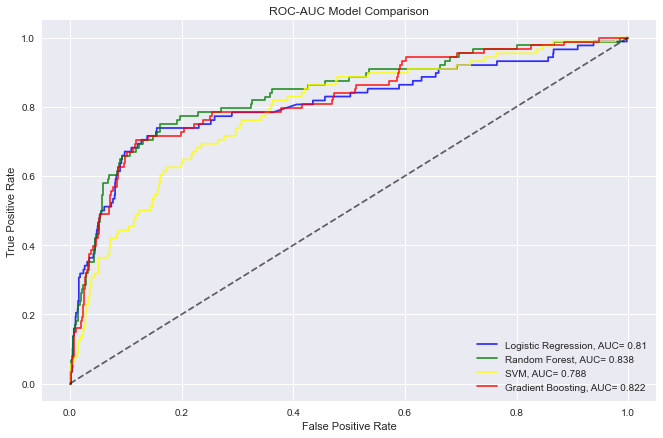

In [16]:
from sklearn.metrics import auc
import matplotlib.style
import matplotlib as mpl
mpl.style.use('seaborn')

plt.figure(figsize=(11,7))
for fpr, tpr, model, color in [(lfpr, ltpr, 'Logistic Regression', 'blue'), (ffpr, ftpr, 'Random Forest', 'green'), (sfpr, stpr, 'SVM', 'yellow'), (gfpr, gtpr, 'Gradient Boosting', 'red')]:
    aucs = auc(fpr, tpr)
    plt.plot(fpr, tpr, c=color, alpha=0.8, label=model +', AUC= '+str(round(aucs, 3)))


plt.plot([0, 1], [0, 1], linestyle='--', c='black', alpha=0.6)
plt.title('ROC-AUC Model Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


Logistic Regression clearly outperformed all other models in terms of ROC-AUC. 

## Final Model Performance Test 

Combine train and validation sets, Count Vectorize on combined data and transform test set

In [17]:
X_final_train_scaled_plus = get_add_word_matrix(X_final_train_scaled)
X_test_scaled_plus = get_add_word_matrix(X_test_scaled)

In [18]:
X_final_train_scaled_plus.shape

(7137, 313)

In [19]:
X_final_train_scaled_plus.head()

,ups,dal,word_count,up_low_ratio,disgust_x,surprise_x,neutral_x,anger_x,sad_x,happy_x,...,work,world,would,wow,wrong,yeah,year,yes,you,your
0,0.025833,0.019307,0.044923,0.019481,0.041148,0.162227,0.026281,0.083970,0.157177,0.187280,...,0,1,0,0,0,0,0,0,0,0
1,0.020000,0.017889,0.007385,0.065217,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
2,0.020556,0.024679,0.006769,0.065217,0.070143,0.150859,0.018771,0.192654,0.220132,0.371625,...,0,0,0,0,0,0,0,0,0,0
3,0.020556,0.015162,0.024000,0.040541,0.001692,0.222616,0.005096,0.179521,0.263892,0.144477,...,0,0,0,0,0,0,0,0,0,0
4,0.050556,0.001091,0.006154,0.026316,0.006342,0.137554,0.851380,0.060101,0.080807,0.475921,...,0,0,0,0,0,0,1,0,0,0


In [20]:
y_final_train1 = y_final_train*1
y_final_train1 = y_final_train1.drop(columns='Unnamed: 0')
y_final_train1 = y_final_train1.to_numpy().ravel()

y_test1 = y_test*1
y_test1 = y_test1.drop(columns='Unnamed: 0')
y_test1 = y_test1.to_numpy().ravel()

Recall/Hit Rate: 0.09090909090909091
False Positive Score: 0.007
Flag Percentage: 0.012


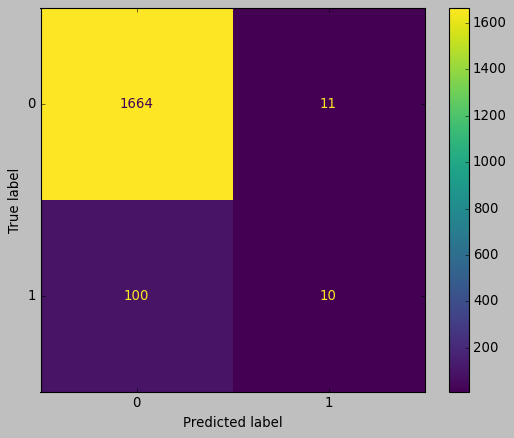


Percent of Total


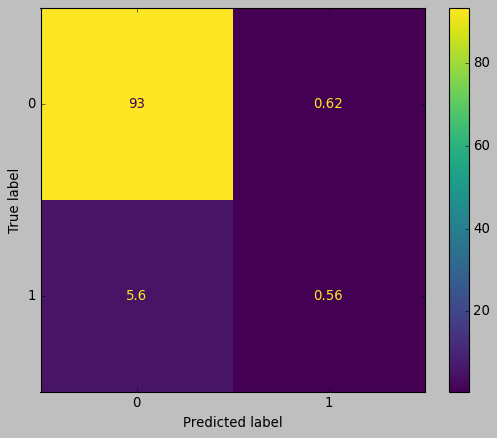

In [21]:
final_model_fitted = best_logreg_classifier.fit(X_final_train_scaled_plus, y_final_train1)
y_pred_final_m = final_model_fitted.predict(X_test_scaled_plus)


final_matrix = confusion_matrix(y_test1, y_pred_final_m, labels=final_model_fitted.classes_)
final_matrix_plot = ConfusionMatrixDisplay(final_matrix, display_labels=final_model_fitted.classes_)
tp = final_matrix[1,1]
tn = final_matrix[0,0]
fp = final_matrix[0,1]
fn = final_matrix[1,0]
    
ffalse_positive_score = fp/(fp+tn)
fflag_percentage = (fp+tp)/(tp+fp+tn+fn)
print('Recall/Hit Rate:',recall_score(y_test1, y_pred_final_m))   
print('False Positive Score: '+str(round(ffalse_positive_score, 3)))
print('Flag Percentage: '+str(round(fflag_percentage, 3)))
mpl.style.use('classic')
final_matrix_plot.plot()
plt.show()

print('\n'+'Percent of Total')
percent_matrix = ConfusionMatrixDisplay(100*(final_matrix/np.sum(final_matrix)), display_labels=final_model_fitted.classes_)
percent_matrix.plot()
plt.show()



## Choosing the Threshold

In [22]:
def final_metrics(model, X_test, y_test, threshold):
    y_pred = (model.predict_proba(X_test)[:,1] >= threshold).astype('int')
    c_matrix = confusion_matrix(y_test, y_pred)
    
    tp = c_matrix[1,1]
    tn = c_matrix[0,0]
    fp = c_matrix[0,1]
    fn = c_matrix[1,0]
    
    false_positive_score = fp/(fp+tn)
    flag_percentage = (fp+tp)/(tp+fp+tn+fn)
    return ([precision_score(y_test, y_pred), recall_score(y_test, y_pred), flag_percentage])
    

In [23]:
threshold_df = pd.DataFrame(columns=['Precision','Recall','Flag_Percentage'])

for threshold in np.arange(0.04,.8,.01):
    
    threshold_df.loc[threshold] = final_metrics(final_model_fitted, X_test_scaled_plus, y_test1, threshold)

We want to flag below 10% of all comments. This can easily be changed depending on the business case. We can see below that even a flag percentage of 4.08% results in a recall of 30.1%. 

In [24]:
threshold_df.loc[(threshold_df['Flag_Percentage'] <= 0.10) & (threshold_df['Recall'] > 0.30)]

,Precision,Recall,Flag_Percentage
0.13,0.343373,0.518182,0.092997
0.14,0.380952,0.509091,0.082353
0.15,0.406015,0.490909,0.074510
0.16,0.415929,0.427273,0.063305
0.17,0.430000,0.390909,0.056022
0.18,0.419355,0.354545,0.052101
0.19,0.426829,0.318182,0.045938


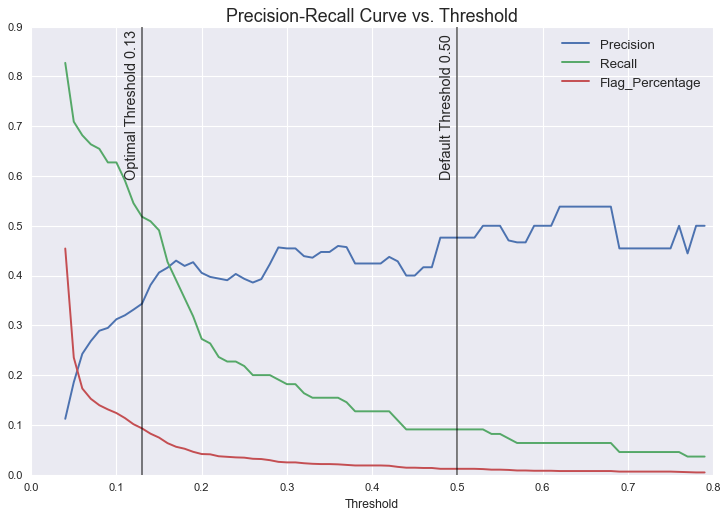

In [25]:
mpl.style.use('seaborn')
thresh_graph = threshold_df.plot(figsize=[11, 7])
thresh_graph.set_title('Precision-Recall Curve vs. Threshold', fontsize=16)
thresh_graph.set_xlabel('Threshold')
thresh_graph.legend(fontsize='medium', loc='upper right')
thresh_graph.axvline(0.5, c='black', alpha=0.5)
thresh_graph.text(0.48, 0.60, 'Default Threshold 0.50', rotation=90, fontsize=13)
thresh_graph.axvline(0.13, c='black', alpha=0.5)
thresh_graph.text(0.11, 0.60, 'Optimal Threshold 0.13', rotation=90, fontsize=13)

plt.show()

In [26]:
optimal_threshold = 0.13 #Optimal was 0.13 with original count vect min_df 0.01

### Final Optimized Model Report

Recall/Hit Rate: 0.5181818181818182
False Positive Score: 0.065
Flag Percentage: 0.093
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      1675
           1       0.34      0.52      0.41       110

    accuracy                           0.91      1785
   macro avg       0.66      0.73      0.68      1785
weighted avg       0.93      0.91      0.92      1785



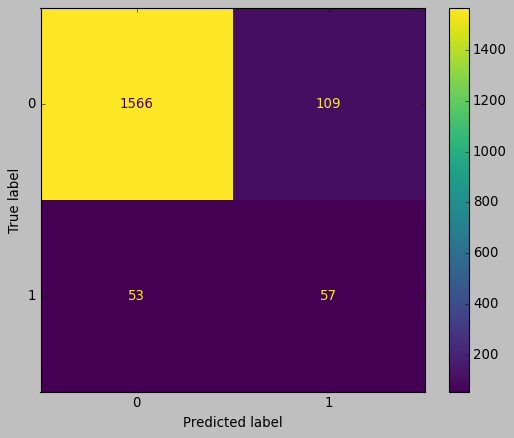


Percent of Total


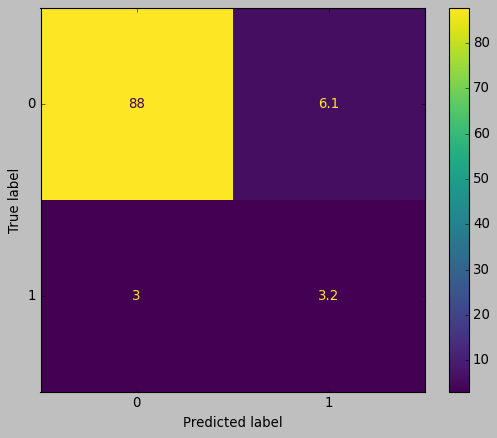

In [27]:
y_pred_final_threshold = (final_model_fitted.predict_proba(X_test_scaled_plus)[:, 1] >= optimal_threshold).astype('int')

mpl.style.use('classic')

final_matrix = confusion_matrix(y_test1, y_pred_final_threshold, labels=final_model_fitted.classes_)
final_matrix_plot = ConfusionMatrixDisplay(final_matrix, display_labels=final_model_fitted.classes_)
tp = final_matrix[1,1]
tn = final_matrix[0,0]
fp = final_matrix[0,1]
fn = final_matrix[1,0]
    
ffalse_positive_score = fp/(fp+tn)
fflag_percentage = (fp+tp)/(tp+fp+tn+fn)
print('Recall/Hit Rate:',recall_score(y_test1, y_pred_final_threshold))   
print('False Positive Score: '+str(round(ffalse_positive_score, 3)))
print('Flag Percentage: '+str(round(fflag_percentage, 3)))
print(classification_report(y_test1, y_pred_final_threshold))
final_matrix_plot.plot()
plt.show()

print('\n'+'Percent of Total')
percent_matrix = ConfusionMatrixDisplay(100*(final_matrix/np.sum(final_matrix)), display_labels=final_model_fitted.classes_)
percent_matrix.plot()
plt.show()

### Taking a look at misclassifications

In [63]:
y_pred_final_threshold

array([0, 0, 0, ..., 0, 0, 1])

In [73]:
misclassified = np.where(y_test1 != y_pred_final_threshold)
misclassified = misclassified[0]
misclassified[:10]

array([ 8,  9, 23, 55, 66, 74, 76, 79, 86, 89])

## Future changes, improvements, and considerations

Since the speed of taking down a bigoted comment should be maximized, using the number of upvotes (or if available, downvotes) as a feature could become potentially less useful in practice depending on the team response time.

The dataset was created to find both particularly toxic and supportive communities. See https://web.archive.org/web/20160304012220/http://idibon.com/toxicity-in-reddit-communities-a-journey-to-the-darkest-depths-of-the-interwebs/ 
It's possible that applying the final model to a platform or sub-group with a less extreme culture would result in less reliable metrics.

